In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
mnase = pd.read_hdf('data/mnase_seq_merged_sampled.h5.z')

In [8]:
orfs = pd.read_csv('data/orfs_cd_paper_dataset.csv').set_index('orf_name')

In [204]:
mnase_0 = mnase[mnase.time == 0.0]

In [688]:
gene = orfs.loc[orfs.index.values[10]]

In [753]:
from src.vit_img_gen import ViTImgGen

# Partitions lengths of fragments into equal sized (length-wise) patches
# Small fragments: 30-79
# Intermediate fragments: 80-129
# Nucleosomal fragments: 130-200
len_cuts = [30, 80, 130, 201]
window = 1024

# Window = 1024
# Resize = 64   (16 downscale)
# Patch size = 4
# 64 / 4 = 16 column patches
# 1024 / 16 = 64 bps per patch
# 12x64 shaped images
patch_size = 4
sublength_resize_height = patch_size # times 3 vertical patches of height
img_width = 64

vit_gen = ViTImgGen(mnase_0, window, sublength_resize_height, len_cuts,
                    img_width, patch_size)


In [754]:
img, scaled_img, smoothed, img_slices = vit_gen.get_mnase_img(gene)

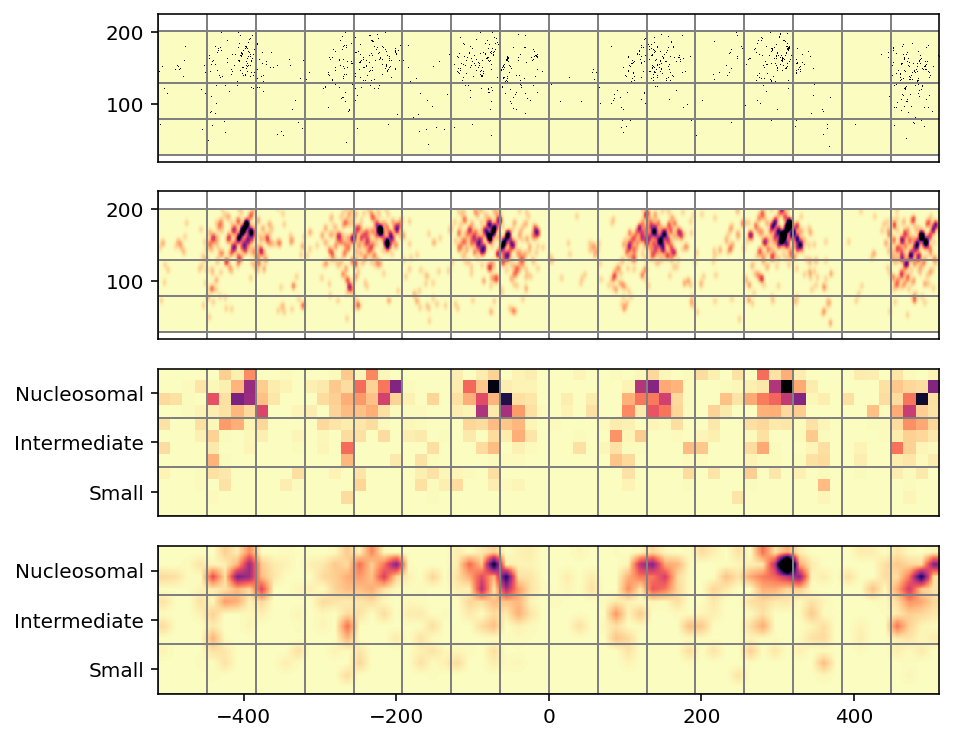

In [755]:
vit_gen.plot_resized_img()